<h2 style='color:purple' align='center'>Build our first neural network in Keras for image classification problem</h2>
**We will use keras fashion MNIST dataset. This consist of 60000 28X28 pixel images and 10000 test images, these images are classified in one of the 10 categories shown below**

In [1]:
import numpy as np
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

%matplotlib inline
fm_train = FashionMNIST('../data/', train=True, transform=ToTensor(), download=True)
fm_test = FashionMNIST('../data/', train=False, transform=ToTensor(), download=True)


In [2]:
fm_train.data.shape

torch.Size([60000, 28, 28])

In [3]:
fm_test.data.shape

torch.Size([10000, 28, 28])

In [4]:
fm_test.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [5]:
fm_test.targets[0]

tensor(9)

In [6]:
fm_test.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

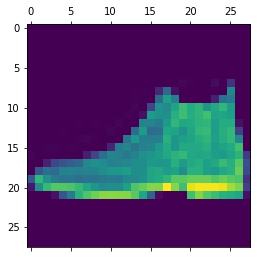

In [7]:
plt.matshow(fm_test.data[0])

In [8]:
batch_size = 64
from torch.utils.data import DataLoader

# Create data loaders.
train_dataloader = DataLoader(fm_train, batch_size=batch_size)
test_dataloader = DataLoader(fm_test, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [9]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print("Using {} device".format(device))
from torch import nn

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [10]:
model.parameters

<bound method Module.parameters of NeuralNetwork(
  (flatten): Flatten()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)>

In [11]:
import torch
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.294361  [    0/60000]
loss: 1.040533  [ 6400/60000]
loss: 0.949559  [12800/60000]
loss: 1.278170  [19200/60000]
loss: 1.100168  [25600/60000]
loss: 1.081110  [32000/60000]
loss: 1.144453  [38400/60000]
loss: 1.102312  [44800/60000]
loss: 1.087688  [51200/60000]
loss: 1.477483  [57600/60000]
Test Error: 
 Accuracy: 59.9%, Avg loss: 1.080718 

Epoch 2
-------------------------------
loss: 0.730825  [    0/60000]
loss: 0.778391  [ 6400/60000]
loss: 0.817378  [12800/60000]
loss: 1.222296  [19200/60000]
loss: 0.929485  [25600/60000]
loss: 1.057325  [32000/60000]
loss: 1.106271  [38400/60000]
loss: 1.077394  [44800/60000]
loss: 1.017128  [51200/60000]
loss: 1.414885  [57600/60000]
Test Error: 
 Accuracy: 60.6%, Avg loss: 1.045821 

Epoch 3
-------------------------------
loss: 0.692905  [    0/60000]
loss: 0.727813  [ 6400/60000]
loss: 0.756432  [12800/60000]
loss: 1.136972  [19200/60000]
loss: 0.897854  [25600/60000]
loss: 1.048167  [32000/600

In [15]:
model.eval()
all_preds = torch.tensor([])
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        all_preds = torch.cat((all_preds, output))
all_preds = all_preds.argmax(dim=1)
all_preds.data

tensor([9, 2, 9,  ..., 8, 9, 5])

In [16]:
all_test = test_dataloader.dataset.targets

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataloader.dataset.targets, all_preds.data)
cm

array([[902,   0,  15,  13,   0,   0,  59,   0,   9,   2],
       [ 16,   0,   3,  28,   0,   0,   2,   0,   0, 951],
       [ 19,   0, 765,  14,   0,   0, 171,   0,   2,  29],
       [ 46,   0,   7, 909,   0,   0,  18,   0,   4,  16],
       [  5,   0, 153,  56,   0,   3, 310,   0,   8, 465],
       [  0,   0,   0,   1,   0, 929,   0,   0,   6,  64],
       [208,   0,  66,  27,   0,   0, 670,   0,  11,  18],
       [  0,   0,   2,   0,   0,  21,   1,   0,   2, 974],
       [  5,   0,   1,   6,   0,   2,   4,   0, 976,   6],
       [  0,   0,   0,   0,   0,   1,   1,   0,   0, 998]])

Text(69.0, 0.5, 'Truth')

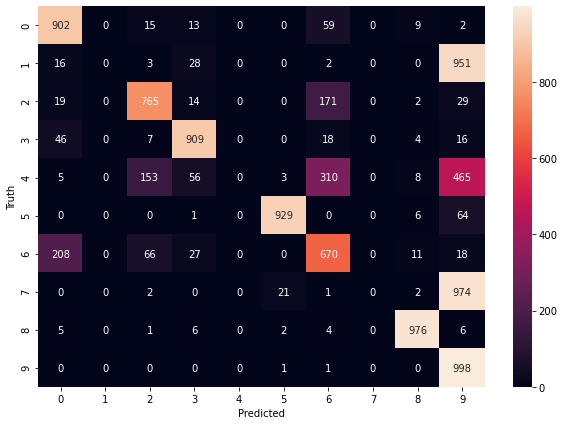

In [18]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')